<a href="https://colab.research.google.com/github/kgolomoleba/SDG8-DEMAND_PREDICTION/blob/main/demand_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Fetching live weather data for Cape Town (last 5 days)...
API request failed for 2025-07-19: 401
API request failed for 2025-07-20: 401
API request failed for 2025-07-21: 401
API request failed for 2025-07-22: 401
API request failed for 2025-07-23: 401


/tmp/ipython-input-3-3336285591.py:60: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data['temperature'].fillna(data['temperature'].mean(), inplace=True)



Data preview:
                        date day_of_week  temperature  event     demand
0 2025-07-19 07:41:45.425244    Saturday          NaN      1  65.080267
1 2025-07-20 07:41:45.425250      Sunday          NaN      0  42.607069
2 2025-07-21 07:41:45.425251      Monday          NaN      0  55.718770
3 2025-07-22 07:41:45.425252     Tuesday          NaN      1  56.692482
4 2025-07-23 07:41:45.425252   Wednesday          NaN      0  47.923560

Model Evaluation:
MAE: 12.24
RMSE: 12.52


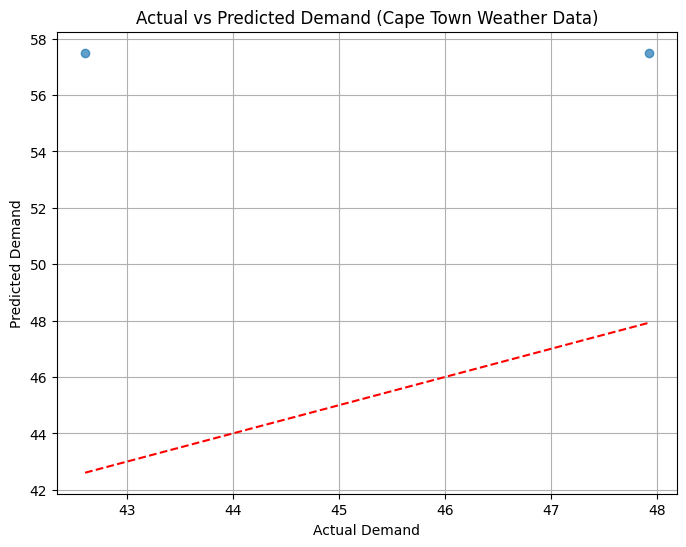

In [3]:
# @title Default title text
import pandas as pd
import numpy as np
import requests
from datetime import datetime, timedelta
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt
import time

# Your OpenWeatherMap API key (keep this secret!)
API_KEY = 'ae20bfada2ac113a0a64bf786627a100'

# Cape Town coordinates
LAT = -33.9249
LON = 18.4241

# Generate 5 days dates because free API allows only last 5 days historical data
# For demonstration, we use only 5 days due to API limits
dates = [datetime.utcnow() - timedelta(days=i) for i in range(5, 0, -1)]

def fetch_temperature(lat, lon, date):
    """Fetch average daily temperature for given lat/lon and date from OpenWeatherMap."""
    timestamp = int(date.timestamp())
    url = (f'https://api.openweathermap.org/data/2.5/onecall/timemachine'
           f'?lat={lat}&lon={lon}&dt={timestamp}&appid={API_KEY}&units=metric')
    response = requests.get(url)
    if response.status_code == 200:
        data = response.json()
        temps = [hour['temp'] for hour in data.get('hourly', [])]
        if temps:
            return sum(temps) / len(temps)
        else:
            print(f"No hourly data for {date.strftime('%Y-%m-%d')}")
            return np.nan
    else:
        print(f"API request failed for {date.strftime('%Y-%m-%d')}: {response.status_code}")
        return np.nan

print("Fetching live weather data for Cape Town (last 5 days)...")
temperatures = []
for dt in dates:
    temp = fetch_temperature(LAT, LON, dt)
    temperatures.append(temp)
    time.sleep(1)  # pause to avoid hitting API limits

day_of_week = [dt.strftime('%A') for dt in dates]

# Create event flags randomly for demo purposes
event_flag = np.random.choice([0, 1], size=len(dates), p=[0.8, 0.2])

data = pd.DataFrame({
    'date': dates,
    'day_of_week': day_of_week,
    'temperature': temperatures,
    'event': event_flag
})

# Fill missing temps with mean if any
data['temperature'].fillna(data['temperature'].mean(), inplace=True)

# Generate synthetic demand for demo
demand = (50
          + 10 * pd.Series(day_of_week).isin(['Friday', 'Saturday']).astype(int)
          + 5 * event_flag
          + np.random.normal(0, 5, size=len(dates)))
data['demand'] = demand

print("\nData preview:")
print(data)

# Prepare features and target
X = pd.get_dummies(data[['day_of_week', 'temperature', 'event']], drop_first=True)
y = data['demand']

# Train/test split (here small data, so 60/40 split)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)

# Train Random Forest model
model = RandomForestRegressor(random_state=42)
model.fit(X_train, y_train)

# Predict and evaluate
y_pred = model.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print(f"\nModel Evaluation:\nMAE: {mae:.2f}\nRMSE: {rmse:.2f}")

# Plot Actual vs Predicted demand
plt.figure(figsize=(8,6))
plt.scatter(y_test, y_pred, alpha=0.7)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel("Actual Demand")
plt.ylabel("Predicted Demand")
plt.title("Actual vs Predicted Demand (Cape Town Weather Data)")
plt.grid(True)
plt.show()
